In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
import numpy as np
import cv2
from scipy import signal
from collections import deque

In [2]:
SRC_PTS = [[490, 482],[810, 482],[1250, 720], [40, 720]]
DST_PTS = [[0, 0], [1280, 0],[1250, 720], [40, 720]]

def draw_corners(x, y): 
    object_pts = []
    img_points = []

    o = np.zeros((x*y,3), np.float32)
    o[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)

    for fname in glob.glob("camera_cal/calibration*.jpg"):
        img = cv2.imread(fname)
        grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(grayscaled, (x, y), None)
        if ret is True:
            img_points.append(corners)
            object_pts.append(o)
            cv2.drawChessboardCorners(img, (x, y), corners, ret)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
            ax1.set_title('Original image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Image with corners', fontsize=18)
    
    return (object_pts, img_points)

def undistort(img, object_pts, img_points, should_display=True):
    if isinstance(img, str):
        img = cv2.imread(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( \
        object_pts, img_points, (img.shape[1], img.shape[0]),None,None \
    )
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    if should_display is True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img) 
        ax1.set_title('Original image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistored image', fontsize=30)
    return dst

def apply_birds_eye(img, should_display=True):
    img_shape = (img.shape[1], img.shape[0])
    
    src = np.float32(SRC_PTS)
    dst = np.float32(DST_PTS)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_shape)
    
    if should_display is True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M, Minv

def apply_binary_thresholds(img, thresholds={  \
      's': {'min': 180, 'max': 255}, \
      'l': {'min': 255, 'max': 255},   \
      'b': {'min': 155, 'max': 200}  \
    } , should_display=True): 
    
    S = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]  
    L = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    B = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2] 

    s_bin = np.zeros_like(S)
    s_bin[(S >= thresholds['s']['min']) & (S <= thresholds['s']['max'])] = 1
    b_bin = np.zeros_like(B)
    b_bin[(B >= thresholds['b']['min']) & (B <= thresholds['b']['max'])] = 1
    l_bin = np.zeros_like(L)
    l_bin[(L >= thresholds['l']['min']) & (L <= thresholds['l']['max'])] = 1
    
    full_bin = np.zeros_like(s_bin)
    full_bin[(l_bin == 1) | (b_bin == 1) | (s_bin == 1)] = 1

    if should_display is True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.set_title('original image', fontsize=16)
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        ax2.set_title('all thresholds', fontsize=16)
        ax2.imshow(full_bin, cmap='gray')
        
    return full_bin

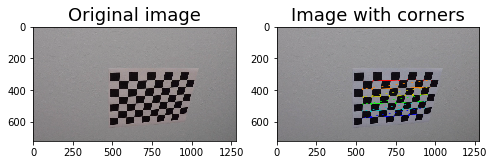

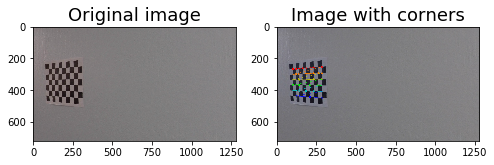

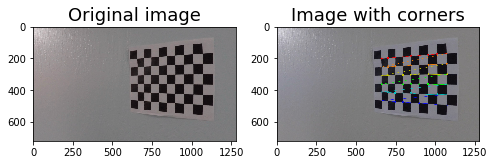

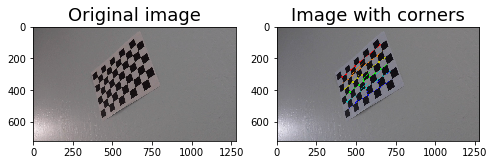

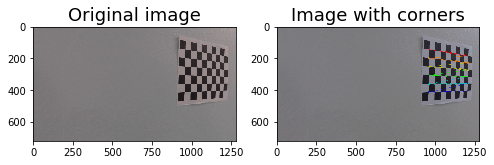

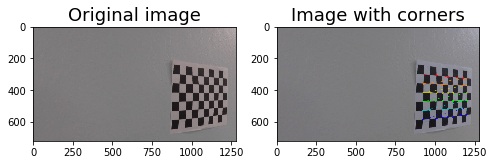

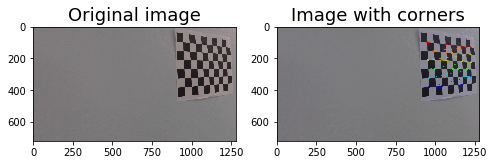

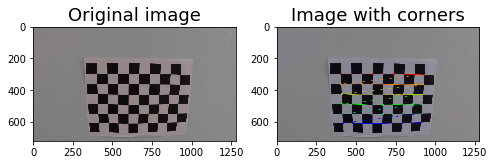

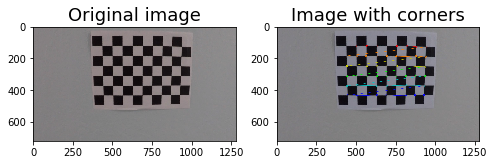

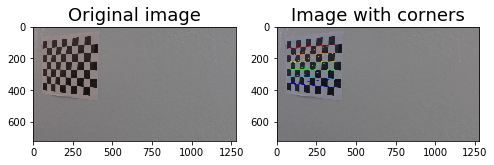

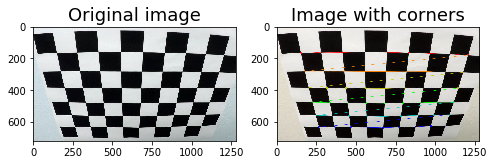

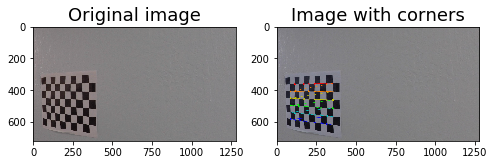

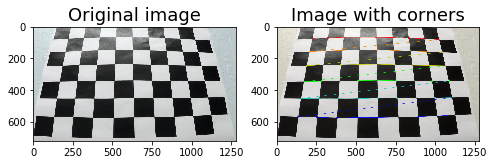

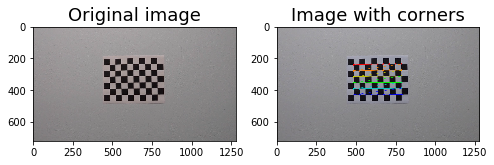

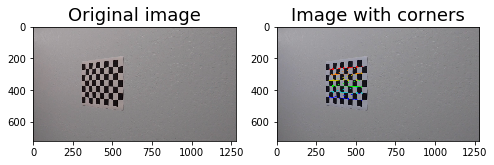

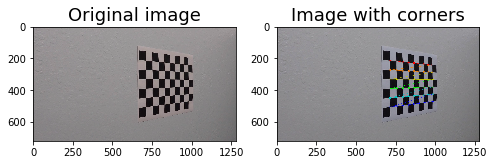

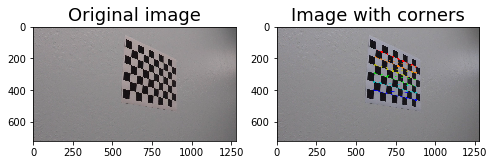

In [3]:
(object_pts, img_points) = draw_corners(9,6)

array([[[ 26,  25,  29],
        [ 26,  25,  29],
        [ 26,  25,  29],
        ..., 
        [232, 231, 233],
        [232, 231, 233],
        [234, 232, 234]],

       [[ 27,  25,  29],
        [ 28,  24,  29],
        [ 27,  24,  29],
        ..., 
        [232, 231, 233],
        [232, 231, 233],
        [234, 231, 233]],

       [[ 28,  25,  30],
        [ 29,  25,  30],
        [ 29,  25,  30],
        ..., 
        [233, 230, 232],
        [233, 230, 232],
        [233, 230, 232]],

       ..., 
       [[220, 219, 221],
        [219, 218, 220],
        [219, 218, 220],
        ..., 
        [  8,  11,  12],
        [  7,  11,  12],
        [  8,  12,  13]],

       [[220, 219, 221],
        [219, 218, 220],
        [218, 217, 219],
        ..., 
        [  9,  11,  12],
        [  7,  11,  12],
        [  8,  12,  13]],

       [[220, 219, 221],
        [220, 219, 221],
        [220, 219, 221],
        ..., 
        [ 10,  11,  13],
        [  9,  11,  13],
        [  9,  12,

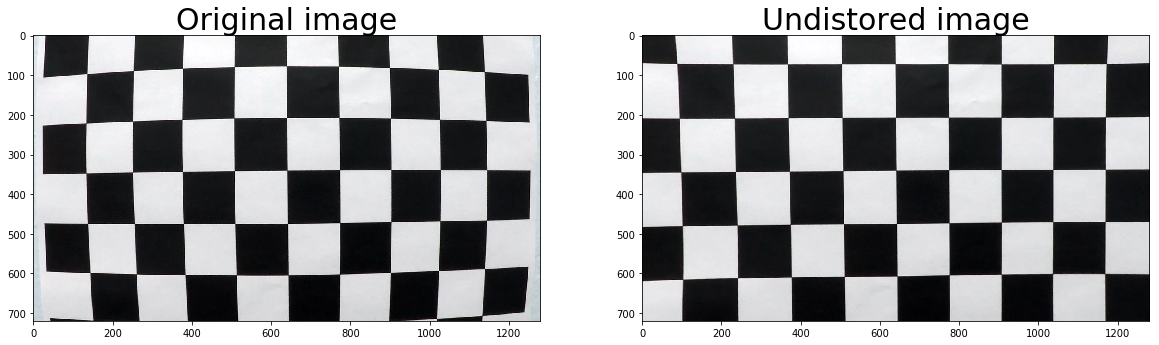

In [64]:
# for fname in glob.glob("camera_cal/calibration*.jpg"):
#     undistort(fname, object_pts, img_points)

undistort("camera_cal/calibration1.jpg", object_pts, img_points)

array([[[200, 153,  97],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [197, 150,  88],
        [196, 149,  87],
        [194, 147,  85]],

       [[201, 154,  98],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [194, 147,  85]],

       [[201, 154,  98],
        [201, 154,  98],
        [201, 154,  98],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [195, 148,  86]],

       ..., 
       [[104,  89, 103],
        [104,  90, 104],
        [105,  91, 105],
        ..., 
        [100, 107, 126],
        [101, 108, 127],
        [ 97, 104, 123]],

       [[103,  91, 105],
        [104,  92, 106],
        [105,  92, 107],
        ..., 
        [ 99, 106, 125],
        [ 99, 106, 125],
        [ 97, 104, 123]],

       [[105,  94, 110],
        [105,  94, 110],
        [104,  94, 110],
        ..., 
        [100, 107, 126],
        [100, 107, 126],
        [100, 107,

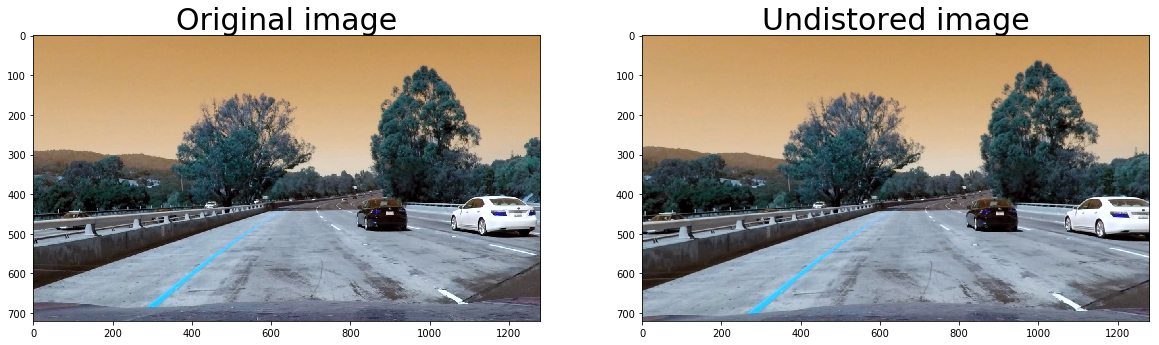

In [65]:
# for fname in glob.glob("test_images/test*.jpg"):
#     undistort(fname, object_pts, img_points)

undistort("test_images/test1.jpg", object_pts, img_points)

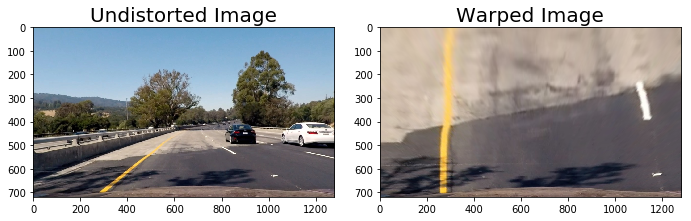

In [5]:
# for fname in glob.glob("test_images/test*.jpg"):
#     undistorted = undistort(fname, object_pts, img_points, should_display=False)
#     apply_birds_eye(undistorted)

orig = cv2.imread("test_images/test4.jpg")
undistorted = undistort(orig, object_pts, img_points, should_display=False)
warped, M, Minv = apply_birds_eye(undistorted, should_display=True)

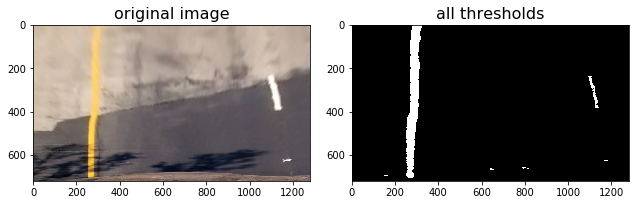

In [6]:
# for image in glob.glob('test_images/test*.jpg'):
#     u = undistort(image, object_pts, img_points, should_display=False)
#     w, M, Minv = apply_birds_eye(u, should_display=False)
#     b_eye_bin = apply_binary_thresholds(w)
b_eye_bin = apply_binary_thresholds(warped)

lt []
rt []
lt [217 241]
rt [488 506]
lt [215 246]
rt []
lt [230 231 261]
rt []
lt [234 265]
rt [423 442]
lt [233 267]
rt []


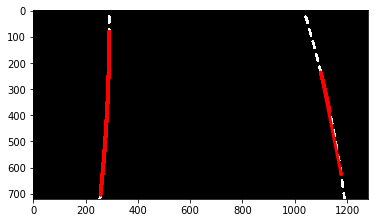

In [8]:
pps = (orig.shape[0] - 50) / 6
g_rad = 300
kernal_size = 51
x_offset = 40
slate = np.zeros((720, 1280))
c_slate = cv2.cvtColor(slate.astype(np.uint8), cv2.COLOR_GRAY2RGB)
shape = orig.shape
half = orig.shape[1] // 2

def polynomial_lines(y, ms):
    return ms[0]*y**2 + ms[1]*y + ms[2]

def draw_polynomial(image, fn, ms, steps):
    pps = image.shape[0] // steps

    for i in range(steps):
        l = i * pps
        r = l + pps

        lp = (int(fn(l, ms)), l)
        rp = (int(fn(r, ms)), r)

        if i % 2 == 1:
            image = cv2.line(image, rp, lp, [255, 0, 0], 10)

    return image

def fit_polynomial(x, y):
    res = np.polyfit(x, y, 2)
    fx = res[0]*x**2 + res[1]*x + res[2]
    return fx, res

def multi_flatten(lx, ly, rx, ry):
    return ( \
        np.array([x \
             for i in lx \
             for x in i]), \
        np.array([x \
             for i in ly \
             for x in i]), \
        np.array([x \
             for i in rx \
             for x in i]), \
        np.array([x \
             for i in ry \
             for x in i]), \
    )

def get_pxs(img, xm, ym, size):
    window = img[ \
        int( \
            ym - size \
        ):int( \
            ym + size \
        ), int( \
            xm - size \
        ):int( \
            xm + size \
        ) \
    ]

    x, y = (window.T == 1).nonzero()
    return x + xm - size, y + ym - size

def histo(img, offset=50, steps=6,
                     g_rad=200, kernal_size=51,
                     x_offset=50):
    
    height = img.shape[0]
    o_height = height - offset
    width = img.shape[1]
    half = img.shape[1] // 2
    pps = o_height / steps
    
    lx_arr = []
    ly_arr = []
    rx_arr = []
    ry_arr = []

    for step in range(steps):
        lxm = []
        rxm = []
        ym = []
        ly = height - (step * pps) + offset
        ry = ly - pps + offset

        hist = np.sum( \
            img[ \
                int( \
                     ry \
                ):int( \
                    ly \
                ), int(x_offset):int(width - x_offset) \
            ], axis=0 \
        )

        smoothened = signal.medfilt(hist, kernal_size)

        lt = np.array(signal.find_peaks_cwt(smoothened[:half], np.arange(1, 10)))
        rt = np.array(signal.find_peaks_cwt(smoothened[half:], np.arange(1, 10)))
        
        print("lt", lt)
        print("rt", rt)

        if len(lt) > 0:
            lxm.append(max(lt))

        if len(rt) > 0:
            rxm.append(max(rt) + half)

        if len(lt) > 0 or len(rt) > 0:
            ym.append((ly + ry) // 2)
            
        for lx_centre, centre_y in zip(lxm, ym):
            left_x_additional, left_y_additional = get_pxs(img, lx_centre,
                                                                       centre_y, g_rad // 2)

            lx_arr.append(left_x_additional)
            ly_arr.append(left_y_additional)
    
        for rx_centre, centre_y in zip(rxm, ym):
            right_x_additional, right_y_additional = get_pxs(img, rx_centre,
                                                                         centre_y, g_rad // 2)
            
            rx_arr.append(right_x_additional)
            ry_arr.append(right_y_additional)

    if len(rx_arr) == 0 or len(lx_arr) == 0:
        x_offset = 0

        lx_arr = []
        ly_arr = []
        rx_arr = []
        ry_arr = []

        for step in range(steps):
            lxm = []
            rxm = []
            ym = []

            ly = height - (step * pps) + offset
            ry = ly - pps + offset

            hist = np.sum(
                img[
                    int(ry):int(ly),
                    int(x_offset):int(width - x_offset)
                ], axis=0)

            smoothened = signal.medfilt(hist, kernal_size)
            lt = np.array(signal.find_peaks_cwt(smoothened[:half], np.arange(1, 10)))
            rt = np.array(signal.find_peaks_cwt(smoothened[half:], np.arange(1, 10)))
            if len(lt) > 0:
                lxm.append(max(lt))

            if len(rt) > 0:
                rxm.append(max(rt) + half)

            if len(lt) > 0 or len(rt) > 0:
                ym.append((ly + ry) // 2)

            for lx_centre, centre_y in zip(lxm, ym):
                lx_additional, ly_additional = get_pxs(img, lx_centre,
                                                                           centre_y, g_rad // 2)
                lx_arr.append(lx_additional)
                ly_arr.append(ly_additional)

            for rx_centre, centre_y in zip(rxm, ym):

                right_x_additional, right_y_additional = get_pxs(img, rx_centre,
                                                                             centre_y, g_rad // 2)
                rx_arr.append(right_x_additional)
                ry_arr.append(right_y_additional)

    return multi_flatten(lx_arr, ly_arr, rx_arr, ry_arr)

from scipy import signal

lx, ly, rx, ry = histo(b_eye_bin, x_offset=x_offset)

lf, lcs = fit_polynomial(ly, lx)
rf, rcs = fit_polynomial(ry, rx)

plt.plot(lf, ly, color='red', linewidth=3)
plt.plot(rf, ry, color='red', linewidth=3)

# polyfit_left = draw_polynomial(slate, lane_poly, lcs, 30)
b_eye_poly = draw_polynomial(draw_polynomial(slate, polynomial_lines, lcs, 30), polynomial_lines, rcs, 30)
cv2.imwrite('output_images/test1_birdseye_poly.jpg',b_eye_poly)
plt.imshow(b_eye_poly, cmap="gray")

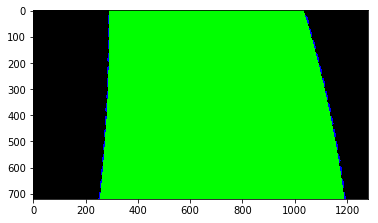

In [9]:
def paint_over_lane_lines(canvas, lcs, rcs):
    for i in range(0, 720):
        canvas[i][int(polynomial_lines(i, lcs)):int(polynomial_lines(i, rcs))] = 1
    return canvas

painted_b_eye = c_slate
painted_b_eye[b_eye_poly > 1] = [0,0,255]
painted_area = paint_over_lane_lines(slate, lcs, rcs)
painted_b_eye[painted_area == 1] = [0,255,0]
cv2.imwrite('output_images/test1_birdseye_paintedover.jpg',painted_b_eye)
plt.imshow(painted_b_eye)

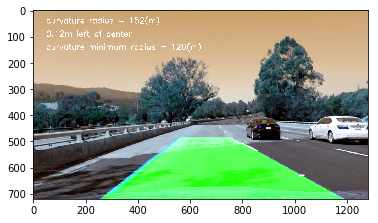

In [10]:
def annotate(img, curvature, pos, curve_min):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'curvature radius = %d(m)' % (curvature / 128 * 3.7), (50, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(img, '%.2fm %s of center' % (np.abs(pos / 12800 * 3.7), "left"), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'curvature minimum radius = %d(m)' % (curve_min / 128 * 3.7), (50, 150), font, 1, (255, 255, 255), 2)

def pos_cen(y, left_poly, right_poly):
    return (1.5 * polynomial_lines(y, left_poly)
              - polynomial_lines(y, right_poly)) / 2

lc_radius = np.absolute(((1 + (2 * lcs[0] * 500 + lcs[1])**2) ** 1.5) \
                /(2 * lcs[0]))
rc_radius = np.absolute(((1 + (2 * rcs[0] * 500 + rcs[1]) ** 2) ** 1.5) \
                 /(2 * rcs[0]))

ll_img = cv2.add( \
    cv2.warpPerspective( \
        painted_b_eye, Minv, (shape[1], shape[0]), flags=cv2.INTER_LINEAR \
    ), undistorted \
) 
plt.imshow(ll_img)
annotate(ll_img, curvature=(lc_radius + rc_radius) / 2, 
                     pos=pos_cen(719, lcs, rcs), 
                     curve_min=min(lc_radius, rc_radius))
plt.imshow(ll_img)

In [17]:
class Line:
    def __init__(self):
        self.found_in_prev_frame = False
        self.MAX_LENGTH = 10
        self.prev_x = None
        self.prec_y = None
        self.x_intercept = deque(maxlen=self.MAX_LENGTH)
        self.high = deque(maxlen=self.MAX_LENGTH)
        self.lastx_intercept = None
        self.last_high = None
        self.curve_radius = None
        self.c0 = deque(maxlen=self.MAX_LENGTH)
        self.c1 = deque(maxlen=self.MAX_LENGTH)
        self.c2 = deque(maxlen=self.MAX_LENGTH)
        self.polyx = None
        self.pts = []
        self.num_frames = 0
        self.pixel_search_window = 25
        
    def directed_search(self, x_pts, y_pts):
        DECREMENT_BY = 90
        HALF = 640
        height = 720
        xs = []
        ys = []
        if self.found_in_prev_frame == True: 
            B = HALF - 10
            while B >= 0:
                
                y = np.mean([height,B])
                x = ( \
                    (np.mean(self.c0))*y**2  \
                    + (np.mean(self.c1))*y \
                    + (np.mean(self.c2)) \
                )
                
                found = np.where( \
                    self.found_x_in_window(x, x_pts) \
                    & \
                    self.found_y_in_window(y_pts, B, height) \
                )
                
                x_window, y_window = x_pts[found], y_pts[found]
                
                if np.sum(x_window) != 0:
                    np.append(xs, x_window)
                    np.append(ys, y_window)
                height -= DECREMENT_BY
                B -= DECREMENT_BY
                
        if np.sum(xs) == 0: 
            self.found_in_prev_frame = False 
        return xs, ys, self.found_in_prev_frame
    
    def blind_histogram_search(self, x_pts, y_pts, img):
        DECREMENT_BY = 90
        HALF = img.shape[1] // 2
        height = img.shape[0]
        xs = []
        ys = []
        
        if self.found_in_prev_frame == False: 
            B = HALF - 10
            while B >= 0:
                
                hist = np.sum(img[B:height,:], axis=0)
                
                if self == Right_Lane:
                    peak = np.argmax(hist[HALF:]) + HALF
                else:
                    peak = np.argmax(hist[:HALF])
                    
                found = np.where( \
                    self.found_x_in_window(peak, x_pts) \
                    & \
                    self.found_y_in_window(y_pts, B, height) \
                )
                
                x_window, y_window = x_pts[found], y_pts[found]
                
                if np.sum(x_window) != 0:
                    xs.extend(x_window)
                    ys.extend(y_window)
                height -= DECREMENT_BY
                B -= DECREMENT_BY
                
        if np.sum(xs) > 0:
            self.found_in_prev_frame = True
        else:
            ys = self.prev_y
            xs = self.prev_x
        return xs, ys, self.found_in_prev_frame
    
    def found_x_in_window(self, peak, pts):
        return ( \
            (pts < (peak + self.pixel_search_window)) \
            & \
            ((peak - self.pixel_search_window) < pts) \
        )
    
    def found_y_in_window(self, pts, B, height):
        return ( \
            (pts > B) & (pts < height) \
        )
    
    def curve_rad(self, xs, ys):
        fit = np.polyfit( \
            ys*30. / 720, \
            xs*3.7 / 700, 2 \
        )
        return ((1 + (2*fit[0]*np.max(ys) + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    def sort(self, xs, ys):
        s = np.argsort(ys)
        return xs[s], ys[s]


def poly_intercepts(poly):
    return ( 
        poly[0]*720**2 + poly[1]*720 + poly[2], 
        poly[0]*0**2 + poly[1]*0 + poly[2] 
    )
    
def perspective_transform(src, dst, img, shape_tuple):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, shape_tuple)
    return M, warped

def to_float_arr(arg):
    return np.array(arg).astype(np.float32)

def lane_search(lane, xpts, ypts, img):
    if lane.found_in_prev_frame == True:
        dirx, diry, found_in_prev_frame = \
            lane.directed_search(xpts, ypts)
        
    if lane.found_in_prev_frame == False:
        dirx, diry, found_in_prev_frame = \
            lane.blind_histogram_search(xpts, ypts, img)
            
    return dirx, diry, found_in_prev_frame

def recalc_intercept(struct, val):
    struct.append(val)
    return np.mean(struct), struct
    


def pipeline(img):
    height = img.shape[0]
    width = img.shape[1]
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        object_pts, img_points, (width, height), None, None
    )
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    M, warped = perspective_transform(src, dst, undistorted_img, (width, height))
    bin_thresholds_dict = {  
      'l': {'min': 215, 'max': 255},  
      'b': {'min': 145, 'max': 200} 
    } 
    
    B = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    L = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    b_bin = np.zeros_like(B)
    b_bin[(B >= bin_thresholds_dict['b']['min']) & (B <= bin_thresholds_dict['b']['max'])] = 1
    
    l_bin = np.zeros_like(L)
    l_bin[(L >= bin_thresholds_dict['l']['min']) & (L <= bin_thresholds_dict['l']['max'])] = 1

    combined_binary = np.zeros_like(b_bin)
    combined_binary[(l_bin == 1) | (b_bin == 1)] = 1

    detected_x_pts, detected_y_pts = np.nonzero(np.transpose(combined_binary)) 
    

    leftx, lefty, Left_Lane.found_in_prev_frame = lane_search(
        Left_Lane, detected_x_pts, 
        detected_y_pts, combined_binary
    )
    
    rightx, righty, Right_Lane.found_in_prev_frame = lane_search(
        Right_Lane, detected_x_pts, 
        detected_y_pts, combined_binary
    )
    
    coordinates = [leftx, lefty, rightx, righty]
    [leftx, lefty, rightx, righty] = [
        to_float_arr(coordinates[i]) for i in range(len(coordinates))
    ]
            
    left_poly = np.polyfit(lefty, leftx, 2)
  
    (leftx_intercept, left_high) = poly_intercepts(left_poly)
    
    leftx_intercept, Left_Lane.x_intercept = recalc_intercept(
        Left_Lane.x_intercept, leftx_intercept
    )
    
    left_high, Left_Lane.high = recalc_intercept(
        Left_Lane.high, left_high
    )
    
    Left_Lane.lastx_intercept = leftx_intercept
    Left_Lane.last_high = left_high
    
    leftx = np.append(leftx, [leftx_intercept, left_high])
    lefty = np.append(lefty, [720, 0])
    
    leftx, lefty = Left_Lane.sort(leftx, lefty)
    
    Left_Lane.prev_x = leftx
    Left_Lane.prev_y = lefty
    
    left_poly = np.polyfit(lefty, leftx, 2)
    [Left_Lane.c0, Left_Lane.c1, Left_Lane.c2] = [
        np.append(*tup)
        for tup in [
            (Left_Lane.c0, left_poly[0]), 
            (Left_Lane.c1, left_poly[1]), 
            (Left_Lane.c2, left_poly[2])
        ]
    ]

    left_poly = [
        np.mean(i)
        for i in [Left_Lane.c0, Left_Lane.c1, Left_Lane.c2]
    ]
    
    
    left_polyx = left_poly[0]*lefty**2 + left_poly[1]*lefty + left_poly[2]
    Left_Lane.polyx = left_polyx
    
    right_poly = np.polyfit(righty, rightx, 2)
    (rightx_intercept, right_high) = poly_intercepts(right_poly)

    rightx_intercept, Right_Lane.x_intercept = recalc_intercept(
        Right_Lane.x_intercept, rightx_intercept
    )
    
    right_high, Right_Lane.high = recalc_intercept(
        Right_Lane.high, right_high
    )
    
    Right_Lane.lastx_intercept = rightx_intercept
    Right_Lane.last_high = right_high
    
    rightx = np.append(rightx, [rightx_intercept, right_high])
    righty = np.append(righty, [720, 0])
    
    rightx, righty = Right_Lane.sort(rightx, righty)
    
    Right_Lane.prev_x = rightx
    Right_Lane.prev_y = righty
    
    right_poly = np.polyfit(righty, rightx, 2)
    [Right_Lane.c0, Right_Lane.c1, Right_Lane.c2] = [
        np.append(*tup)
        for tup in [
            (Right_Lane.c0, right_poly[0]), 
            (Right_Lane.c1, right_poly[1]), 
            (Right_Lane.c2, right_poly[2])
        ]
    ]
    right_poly = [
        np.mean(i)
        for i in [Right_Lane.c0, Right_Lane.c1, Right_Lane.c2]
    ]
    
    
    right_polyx = right_poly[0]*righty**2 + right_poly[1]*righty + right_poly[2]
    Right_Lane.polyx = right_polyx
        
    left_curverad = Left_Lane.curve_rad(leftx, lefty)
    right_curverad = Right_Lane.curve_rad(rightx, righty)
        
    if Left_Lane.num_frames % 3 == 0:
        Left_Lane.curve_radius = left_curverad
        Right_Lane.curve_radius = right_curverad
        
    pos = (rightx_intercept + leftx_intercept) / 2
    distance = abs((640 - pos) * 3.7 / 700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left_Lane.polyx, Left_Lane.prev_y])))])
    pts_right = np.array([np.transpose(np.vstack([right_polyx, Right_Lane.prev_y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (width, height))
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.5, 0)
    
    
    pos_txt = ''   
    
    if pos > 640:
        pos_txt = 'left'
    else: 
        pos_txt = 'right'
        
    distance_txt = '{:.2f}m'.format(distance)
        
    cv2.putText(result, 'vehicle is ' + distance_txt + ' ' + pos_txt + ' of center'.format(distance), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        
    cv2.putText(result, 'curve radius  {}(m)'.format(int((Left_Lane.curve_radius+Right_Lane.curve_radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left_Lane.num_frames += 1
    return result

from moviepy.editor import VideoFileClip
from IPython.display import HTML
Left_Lane = Line()
Right_Lane = Line()
output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(5,40)
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4



 18%|█▊        | 155/876 [02:06<09:48,  1.22it/s]


 35%|███▌      | 309/876 [04:11<07:32,  1.25it/s]


 53%|█████▎    | 463/876 [06:16<05:38,  1.22it/s]


 70%|███████   | 617/876 [08:22<03:30,  1.23it/s]


 88%|████████▊ | 771/876 [10:29<01:25,  1.22it/s]


100%|█████████▉| 875/876 [11:55<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 12min 59s, sys: 12.4 s, total: 13min 11s
Wall time: 11min 56s
